In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
heat_df = pd.read_csv('data/utilities.csv', usecols = ['temp','ccf'])

heat_df = heat_df.loc[~(((heat_df['temp'] == 60) & (heat_df['ccf']==129)) | 
                        ((heat_df['temp'] == 41) & (heat_df['ccf']==16))), :]

# Cross-Validation

We can use the train-test paradigm to help use choose a model. The idea is to further divide the train set into separate parts where we fit the model on one part and evaluate it on another. This approach is called *cross-validation*.  We describe one version of it, called $k$-fold cross-validation*. {numref}`Figure %s <CVDiagram>` shows the idea behind the division of the data.

```{figure} figures/CVDiagram.png
---
name: CVDiagram
---

Five-fold Cross-Validation. 
```

We use cross-validation to select the form of the model. This might be the degree of the polynomial, the number of features to include, or a cut-off for a classification (see {numref}`Chapter %s <ch:logistic>`).  The basic steps behind $k$-fold cross-validation go as follows. 

+ Divide the train set into $k$ parts of roughly the same size, each of these parts are called *folds*. Use the same technique for creating the original train and test set to divide up the train set. Typically, we divide the data at random.

+ Set one fold aside to act as a test set.
    + Fit all models on the remainder of the train data (the training data less the particular fold).
    + Use the fold you set aside to evaluate all of these models.
    
+ Repeat this process $k-1$ more times, where each time you set aside one fold, use the rest of the train set to fit models, and evaluate them on the fold that was set aside.

+ Combine the error in fitting each model across the folds, and choose the model with the smallest error. 

These fitted models will not have identical coefficients across folds. We combine them across folds according to the basic form of the model. In the case of fitting a polynomial, we combine the MSE for each fold according to the degree of the polynomial. In other words, we use the folds to choose the complexity of the model. Once chosen, we refit the model using all of the train set and evaluate it with the test set. (Notice that we haven't used the test set in any of the steps in selecting the model).

Typically, we use a *k* between 5 to 10.  Another choice for $k$ is the number of observations in the train set. This special case is called leave-one-out cross-validation. It's popularity stems from the simplicity in adjusting a lease squares fit to drop one observation.  
Generally, $k$-fold cross-validation takes some computation time since we typically have to refit each model from scratch for each fold. The `scikit-learn` library provides a convenient [`sklearn.model_selection.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class to implement $k$-fold cross-validation.

## Example: Fitting a Bent Line Model with Cross-validation

We will demonstrate $k$-fold cross-validation on the gas consumption example. However, we will fit a different set of models than polynomials. The scatter plot of the data looks like it might be fit well by two connecting line segments. For cold temperatures the relationship between gas consumption and temperature looks roughly linear with a negative slope of about $-4$cubic ft/degree. The gas consumption for warmer months appears to be roughly flat. Rather than fit a polynomial, we can fit a line with a bend in it. 

Suppose that we want the line to bend at 65 degrees. Then we can create a second feature that enables the points 65 and above to have a different slope. We create this feature and fit the bent line model.  

In [3]:
y = heat_df[['ccf']]
X = heat_df[['temp']]

X["temp65p"] = (X['temp'] - 65) * (X['temp'] >= 65 )
bend = LinearRegression().fit(X, y)

We can overlay this fitted "curve" on the scatter plot to see how well it captures the shape of the data.

In [4]:
temp = np.arange(10, 80, 1)
temp65p = (temp - 65) * (temp >= 65)

Xs = pd.DataFrame(data= np.transpose([temp,temp65p]), columns=['temp', 'temp65p'])
y_hats = bend.predict(Xs).flatten()

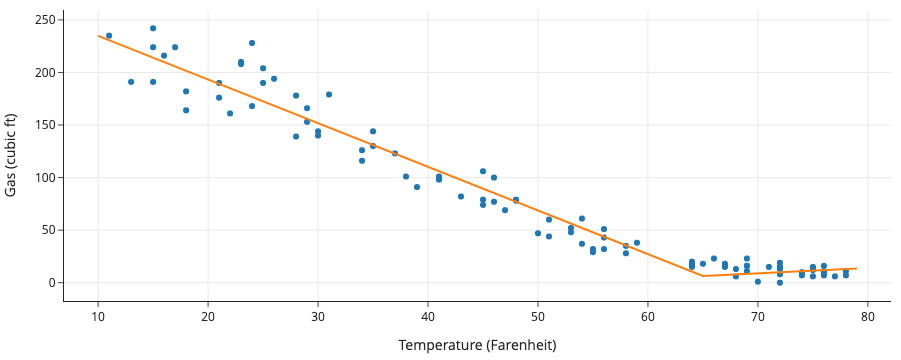

In [5]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=heat_df['temp'], y=heat_df["ccf"], mode='markers'))

fig.add_trace(
    go.Scatter(x=Xs['temp'], y=y_hats))

fig.update_layout(showlegend=False, width=350, height=250,
                 xaxis_title='Temperature (Farenheit)',
                   yaxis_title='Gas (cubic ft)')


fig.show()

This model appears to fit the data much better than the earlier polynomials. There are many bent line models possible. The line might bend at 55 degrees or 60 degrees, and so on. We can use $k$-fold cross-validation to choose the temperature value at which the line bends. Let's consider models from 40 to 69 in increments of 1 degree. For each of these models, we need to create the additional feature to enable the line to bend. 

In [6]:
for i in np.arange(40, 70, 1):
    heat_df[ 'temp'+ i.astype('str') + 'p'] = (heat_df['temp'] - i) * (heat_df['temp'] >= i) 
 
heat_df

,temp,ccf,temp40p,temp41p,...,temp66p,temp67p,temp68p,temp69p
0,29,166,0,0,...,0,0,0,0
1,31,179,0,0,...,0,0,0,0
2,15,224,0,0,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
96,76,11,36,35,...,10,9,8,7
97,55,32,15,14,...,0,0,0,0
98,39,91,0,0,...,0,0,0,0


The first step is to create our train and test sets. We choose 22 observations at random to be placed in the test set. That leaves 75 for the train set.

In [7]:
y = heat_df[['ccf']]
X = heat_df.drop(['ccf'], axis=1)

test_size = 22

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=0)


print(f'  Training set size: {len(X_train)}')
print(f'      Test set size: {len(X_test)}')

  Training set size: 75
      Test set size: 22


Now we can divide the train set into folds. We use three folds so that we have 25 observations in each fold. For each fold, we fit 30 models, one for each bend in the line. 

In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=66)

validation_errors = np.zeros((3, 30))
i = 0

for train_idx, valid_idx in kf.split(X_train):
    
    split_X_train, split_X_valid = X_train.iloc[train_idx, :], X_train.iloc[valid_idx, :]
    split_Y_train, split_Y_valid = y_train.iloc[train_idx, :], y_train.iloc[valid_idx, :]
    
    bent_models = [LinearRegression().fit(split_X_train.iloc[ :, [0,j]], split_Y_train)
        for j in range(1,31)]
    
    bent_preds = [bent_models[j].predict(split_X_valid.iloc[ :, [0,(j+1)]])
         for j in range(30)]
    
    error_bend = [mean_squared_error(split_Y_valid, bent_preds[j].flatten())
         for j in range(30)]
    
    validation_errors[i][ : ] = error_bend
    i = i+1       

Then we combine the validation errors across the 3-folds and plot them against the location of the bend.

In [9]:
totals = [ sum(x)/3 for x in validation_errors.transpose() ]

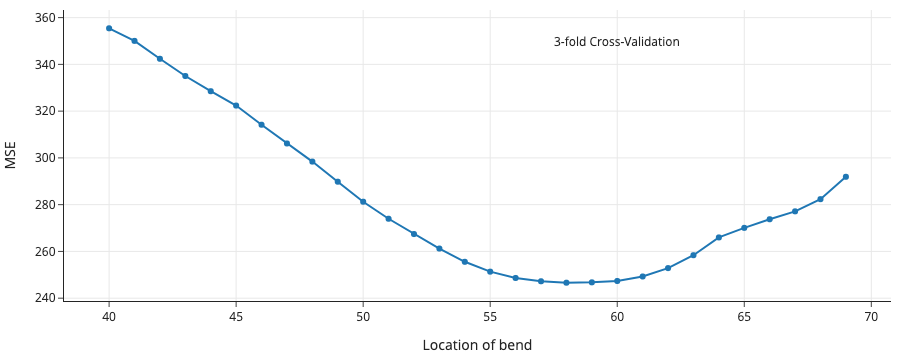

In [10]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=np.arange(40,71,1), y=totals, mode='markers+lines'))

fig.add_annotation(x=60, y=350,
            text="3-fold Cross-Validation", showarrow=False)

fig.update_layout(showlegend=False, width=350, height=250,
                 xaxis_title='Location of bend',
                   yaxis_title='MSE')


fig.show()

The MSE looks quite flat for 57, 58, 59, and 60 degrees. The minimizing value occurs at 58 degrees so we will choose that particular model. To assess this model with the test set, we first we fit it using the entire train set.

In [11]:
bend_final = LinearRegression().fit(X_train.loc[:, ["temp", "temp58p"]], y_train)

y_pred_test = bend_final.predict(X_test.loc[:, ["temp", "temp60p"]])

mean_squared_error(y_test, y_pred_test.flatten())

82.68661029815688

Then we predict the gas consumption for the test set using this model.

In [12]:
y_pred_test = bend_final.predict(X_test.loc[:, ["temp", "temp60p"]])

mean_squared_error(y_test, y_pred_test.flatten())

82.68661029815688

We overlay the bent-line fit on the scatter plot and examine the residuals to get a quick idea as to the quality of the fit.

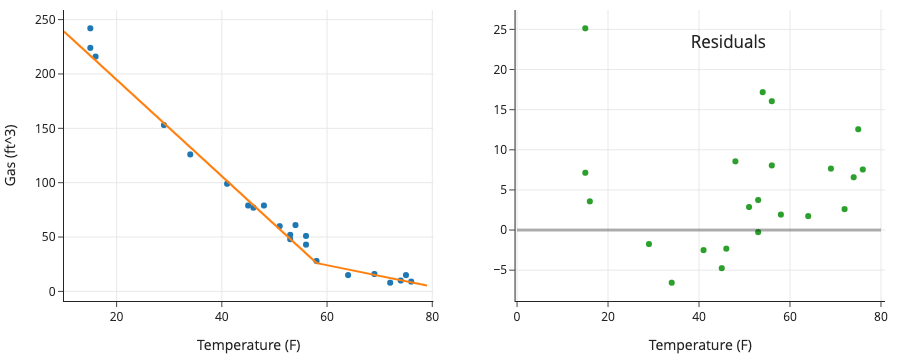

In [13]:
err58 = (y_test - y_pred_test).loc[: , "ccf"]
err58

temp = np.arange(10, 80, 1)
temp58p = (temp - 58) * (temp >= 58)

Xs = pd.DataFrame(data= np.transpose([temp,temp58p]), columns=['temp', 'temp58p'])
y_hats = bend_final.predict(Xs).flatten()


fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=X_test['temp'], y=y_test["ccf"], mode='markers'),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=Xs['temp'], y=y_hats),
    row=1, col=1)
fig.update_xaxes(title='Temperature (F)', row=1, col=1)
fig.update_yaxes(title='Gas (ft^3)', row=1, col=1)


fig.add_trace(
    go.Scatter(x=X_test['temp'], y=err58,
              mode="markers"),
    row=1, col=2)

fig.add_shape(type="line",
    x0=0, y0=0, x1=80, y1=0,
    line=dict(
        color="Black", width=3),
    row=1, col=2)

fig.update_xaxes(title='Temperature (F)', row=1, col=2)

fig.update_layout(height=250, width=550, showlegend=False,
                 title={
        'text': "Residuals",
        'y':0.9,
        'x':0.85,
        'xanchor': 'right',
        'yanchor': 'top'})

fig.show()

The fitted curve looks reasonable, and the size of the residuals is much smaller than those from the polynomial fit.   

For future reference, `scikit-learn` has a [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) method to automatically perform cross-validation, so we don't have to break the data into training and validation sets ourselves. 

Using cross-validation to manage model complexity has a couple critical limitations: typically it requires the complexity to vary discretely; and there may not be a natural way to order the models. 
Rather than changing the dimensions of a sequence of models, we can instead fit a large model and apply constraints on the coefficients. This notion is called regularization and is the topic of the next section. 